# Assignment 1, Penalized Regression:
**Author: Matthew Johnescu**

# Table of Contents:
- [Question Responses](#question-responses)
- [Imports](#imports)
- [Loading Data](#loading-data)
- [Checking Data](#checking-data)
- [Data Preparation](#data-preparation)
- [Running Models](#running-models)
- [Model Predictions Comparrison Visual](#model-predictions-comparrison-visual)
- [Total Price vs Quantity Visual](#total-price-vs-quantity-visual)

# Question Reponses:

**From what perspective are you conducting the analysis? (Who are you? / Who are you working for?):**

I am a data analyst working for an electronics company. The goal is to understand the purchasing behavior of customers and predict the quantity of items purchased using various features like product details, pricing, and customer demographics.

**What is your question?:**

Can we predict the quantity of items purchased by customers based on factors such as product pricing, customer demographics, and additional purchases?

**Describe your dataset(s) including URL (if available):**

The dataset contains sales transaction records of an electronics company, with 20,000 entries. It includes detailed information about customer demographics, product types, pricing, order status, and additional purchases.

URL: https://www.kaggle.com/datasets/cameronseamons/electronic-sales-sep2023-sep2024

Variables include:

- Customer demographics: Age, Gender, Loyalty Member
- Product information: Product Type, SKU, Rating, Total Price, Unit Price
- Transaction details: Order Status, Payment Method, Shipping Type, Add-ons Purchased, Add-on Total


**What is(are) your independent variable(s) and dependent variable(s)? Include variable type (binary, categorical, numeric):**

Independent variables:

- Numeric: Rating, Total Price, Unit Price, Add-on Total
- Categorical: Gender, Loyalty Member, Product Type, Order Status, Payment Method, Shipping Type, Add-ons Purchased

Dependent variable:

- Age (numeric)

**How are your variables suitable for your analysis method?:**

The variables were preprocessed for the regression analysis:
Numeric variables (Rating, Total Price, Unit Price, Add-on Total) were standardized using StandardScaler.
Categorical variables (Gender, Loyalty Member, etc.) were encoded using OneHotEncoder to make them suitable for modeling.
The dependent variable (Quantity) is a numeric variable, making it suitable for Ridge and Lasso Regression, which are designed to predict continuous outcomes.

**What are your conclusions (include references to one or two CLEARLY INDICATED AND IMPORTANT graphs or tables in your output)?:**

Model Performance:

Ridge vs. Lasso Predictions:

The Ridge Regression model had a mean squared error (MSE) of 1.89, whereas the Lasso Regression model had an MSE of 1.94. This indicates that the Ridge model slightly outperformed the Lasso model.
The Cross-Validation MSE for the Ridge model (1.90) was also lower than that for the Lasso model (1.94), suggesting better generalization.

Visualization Analysis:

The "Comparison of Actual vs Predicted Quantity" line plot (First visual) shows that both models follow the trend of the actual quantity closely for reduced data points. The Ridge model's predictions (red crosses) are generally more aligned with the actual values (blue circles), indicating slightly better accuracy over the Lasso model (green crosses).

In the Total Price vs Quantity scatter plots (second and third visuals), both Ridge and Lasso models predicted quantities that followed the general trend of the actual values, but the Ridge predictions (red) had a tighter fit compared to Lasso predictions (green). Both models showed deviations for higher values of Total Price, where the variance in actual quantities increased.


**What are your assumptions and limitations? Did you include any robustness checks?:** 

Assumptions:

Linearity: It is assumed that there is a linear relationship between the features (Total Price, Rating, etc.) and the target variable (Quantity). This assumption may not hold for all data points, especially for high variance areas.
No Multicollinearity: It is assumed that the independent variables are not highly correlated with each other. Multicollinearity could affect the reliability of the model coefficients.

Limitations:

Model Choice: Both Ridge and Lasso are linear regression models, which may not capture complex, non-linear relationships in the data. The relatively low MSE suggests decent performance, but non-linear models might perform even better.
Categorical Features: Some categorical variables (e.g., Product Type, Payment Method) were one-hot encoded, which can increase the dimensionality and impact interpretability.
Missing Data: The dataset initially had missing values, particularly for the Add-ons Purchased column, which were filled with 'Unknown'. This could introduce bias in the model if 'Unknown' doesn't represent the true value distribution.

Robustness Checks:

Cross-Validation: A 5-fold cross-validation was performed to ensure the robustness of both models. The MSE values obtained from cross-validation were consistent with the MSE values from the train-test split, indicating that both models generalize well across different subsets of the data.



# Imports:

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data:

In [70]:
# Add File Path of the CSV file here
file_path = "C:/Users/johne/Downloads/Electronic_sales_Sep2023-Sep2024.csv"
# Reading the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Checking Data:

In [71]:
# Check for missing data in the dataset
missing_data = df.isnull().sum()

# Display basic statistics for the dataset
basic_statistics = df.describe()

# Output missing data and basic statistics
missing_data, basic_statistics

(Customer ID             0
 Age                     0
 Gender                  1
 Loyalty Member          0
 Product Type            0
 SKU                     0
 Rating                  0
 Order Status            0
 Payment Method          0
 Total Price             0
 Unit Price              0
 Quantity                0
 Purchase Date           0
 Shipping Type           0
 Add-ons Purchased    4868
 Add-on Total            0
 dtype: int64,
         Customer ID           Age        Rating   Total Price    Unit Price  \
 count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
 mean   10483.526550     48.994100      3.093950   3180.133419    578.631867   
 std     5631.732525     18.038745      1.223764   2544.978675    312.274076   
 min     1000.000000     18.000000      1.000000     20.750000     20.750000   
 25%     5478.000000     33.000000      2.000000   1139.680000    361.180000   
 50%    10499.500000     49.000000      3.000000   2534.490000    463.960

# Data Preparation: 

In [72]:
# Fill missing values (if any)
df.fillna('Unknown', inplace=True)

# Select Independent variables and target variable
columns_to_drop = [col for col in ['Quantity', 'CustomerID', 'SKU', 'Purchase Date'] if col in df.columns]
X = df.drop(columns=columns_to_drop)  # Drop unrelated columns
y = df['Quantity']

# Preprocessing: OneHotEncode categorical features, scale numerical features for modeling
numeric_features = ['Rating', 'Total Price', 'Unit Price', 'Add-on Total']
categorical_features = ['Gender', 'Loyalty Member', 'Product Type', 'Order Status', 'Payment Method', 'Shipping Type', 'Add-ons Purchased']

# Column Transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Ridge Regression Model
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=1.0))
])

# Lasso Regression Model
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(alpha=0.1))
])

# Running Models:

In [73]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Ridge and Lasso Models
ridge_pipeline.fit(X_train, y_train)
lasso_pipeline.fit(X_train, y_train)

# Predictions
ridge_predictions = ridge_pipeline.predict(X_test)
lasso_predictions = lasso_pipeline.predict(X_test)

# Evaluate Models
ridge_mse = mean_squared_error(y_test, ridge_predictions)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

print(f"Ridge Regression MSE: {ridge_mse}")
print(f"Lasso Regression MSE: {lasso_mse}")

# Robustness Check: Cross-Validation
ridge_cv_scores = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
lasso_cv_scores = cross_val_score(lasso_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')

print(f"Ridge Cross-Validation MSE: {-np.mean(ridge_cv_scores)}")
print(f"Lasso Cross-Validation MSE: {-np.mean(lasso_cv_scores)}")

Ridge Regression MSE: 1.893315025610802
Lasso Regression MSE: 1.9435267224717974
Ridge Cross-Validation MSE: 1.9014162823464769
Lasso Cross-Validation MSE: 1.9426595857332465


# Model Predictions Comparrison Visual:

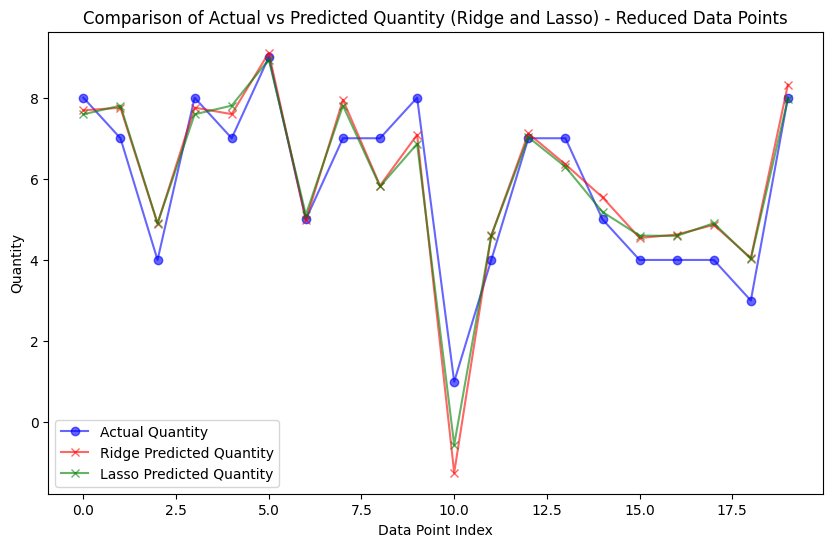

In [67]:
# Import numpy for indexing
import numpy as np

# Create a smaller subset of X_test, y_test, ridge_predictions, and lasso_predictions for less crowded visualization
reduced_indices = np.arange(0, len(y_test), max(1, len(y_test) // 20))  # Select at most 10 data points
X_test_reduced = X_test.iloc[reduced_indices]
y_test_reduced = y_test.iloc[reduced_indices]
ridge_predictions_reduced = ridge_predictions[reduced_indices]
lasso_predictions_reduced = lasso_predictions[reduced_indices]

# Comparing Actual vs Predicted for Ridge and Lasso Models with reduced data points
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_reduced)), y_test_reduced, color='blue', label='Actual Quantity', linestyle='-', marker='o', alpha=0.6)
plt.plot(range(len(y_test_reduced)), ridge_predictions_reduced, color='red', label='Ridge Predicted Quantity', linestyle='-', marker='x', alpha=0.6)
plt.plot(range(len(y_test_reduced)), lasso_predictions_reduced, color='green', label='Lasso Predicted Quantity', linestyle='-', marker='x', alpha=0.6)
plt.xlabel('Data Point Index')
plt.ylabel('Quantity')
plt.title('Comparison of Actual vs Predicted Quantity (Ridge and Lasso) - Reduced Data Points')
plt.legend()
plt.show()



# Total Price vs Quantity Visual:

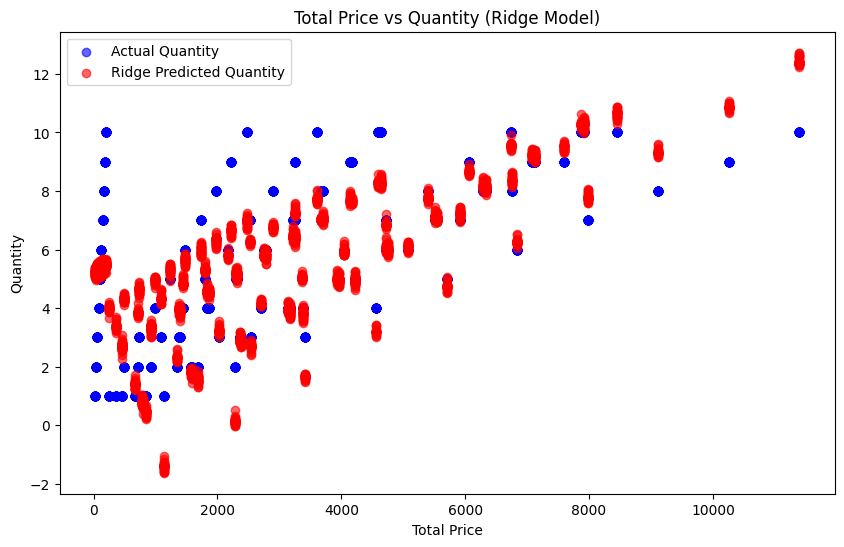

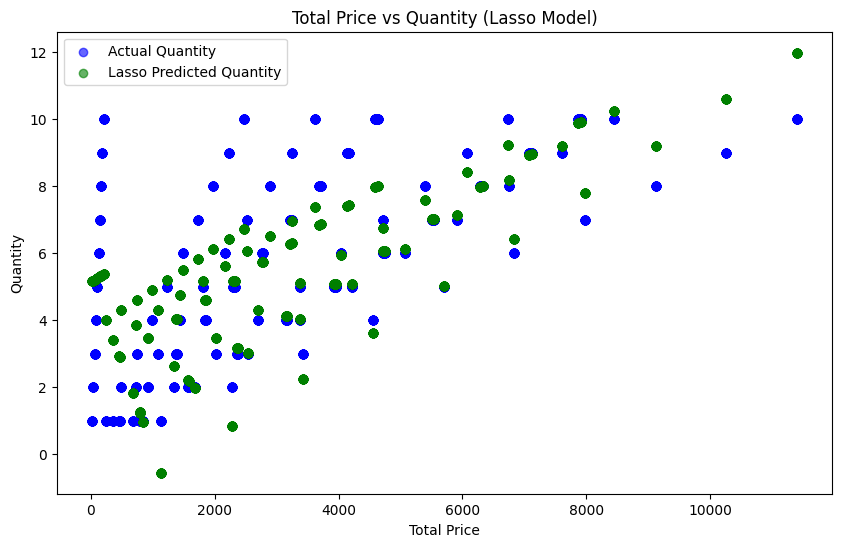

In [77]:
# Scatter plot: Total Price vs Quantity with predictions from Ridge model
plt.figure(figsize=(10, 6))
plt.scatter(X_test['Total Price'], y_test, color='blue', label='Actual Quantity', alpha=0.6)
plt.scatter(X_test['Total Price'], ridge_predictions, color='red', label='Ridge Predicted Quantity', alpha=0.6)
plt.xlabel('Total Price')
plt.ylabel('Quantity')
plt.title('Total Price vs Quantity (Ridge Model)')
plt.legend()
plt.show()

# Scatter plot: Total Price vs Quantity with predictions from Lasso model
plt.figure(figsize=(10, 6))
plt.scatter(X_test['Total Price'], y_test, color='blue', label='Actual Quantity', alpha=0.6)
plt.scatter(X_test['Total Price'], lasso_predictions, color='green', label='Lasso Predicted Quantity', alpha=0.6)
plt.xlabel('Total Price')
plt.ylabel('Quantity')
plt.title('Total Price vs Quantity (Lasso Model)')
plt.legend()
plt.show()

